In [1]:
#
# Load data and scaler
#

import sys
sys.path.append("..")

from helpers.loaders import load_data, load_scaler

X_train, X_test, y_train, y_test = load_data()
scaler = load_scaler()


scale_pos_weight = 19.54


/Users/luis/Desktop/repo-DSML-Course-Ironhack/e - projects/project-2 - stroke assessment/venv_dsml_project2_py311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:23] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/luis/Desktop/repo-DSML-Course-Ironhack/e - projects/project-2 - stroke assessment/venv_dsml_project2_py311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
/Users/luis/Desktop/repo-DSML-Course-Ironhack/e - projects/project-2 - stroke assessment/venv_dsml_project2_py311/lib/python3.11/site-packages/xgboost/training.py:183: UserWarning: [17:40:24] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are

Brier score: 0.0450
AUC-ROC: 0.7308
AUPRC: 0.1422


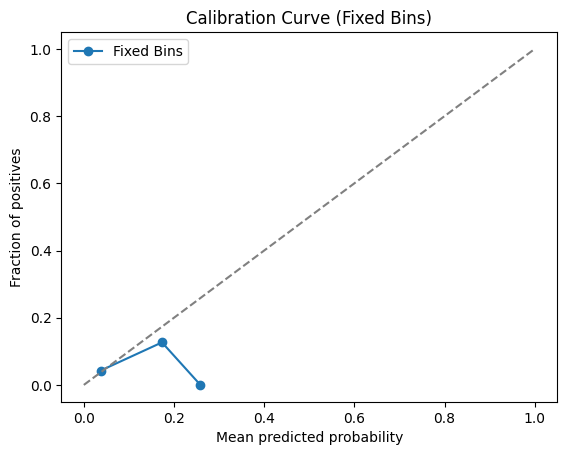

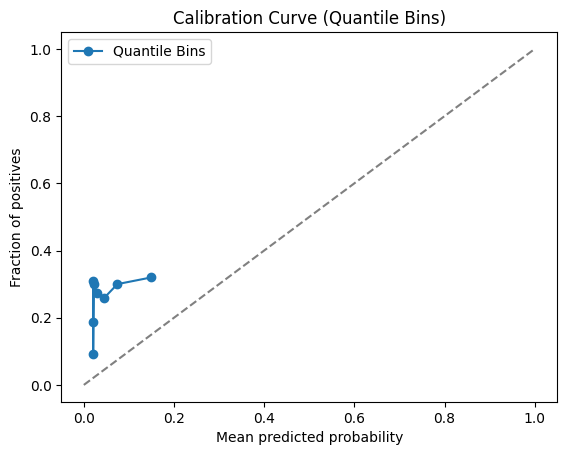

In [2]:
import xgboost as xgb
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss, roc_auc_score, average_precision_score
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Compute scale_pos_weight
n_neg = (y_train == 0).sum()
n_pos = (y_train == 1).sum()
scale_pos_weight = n_neg / n_pos

print(f"scale_pos_weight = {scale_pos_weight:.2f}")

# Step 1 — Train XGBoost base model
xgb_model = xgb.XGBClassifier(
    n_estimators=200,
    learning_rate=0.05,
    scale_pos_weight=scale_pos_weight,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Step 2 — Calibrate with Platt scaling (sigmoid)
calibrated_model = CalibratedClassifierCV(xgb_model, method='sigmoid', cv=5)
calibrated_model.fit(X_train, y_train)

# Step 3 — Predict probabilities
y_test_proba = calibrated_model.predict_proba(X_test)[:, 1]

# Metrics
brier = brier_score_loss(y_test, y_test_proba)
auc_roc = roc_auc_score(y_test, y_test_proba)
auprc = average_precision_score(y_test, y_test_proba)

print(f"Brier score: {brier:.4f}")
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"AUPRC: {auprc:.4f}")

# Calibration Curve — fixed bins
fraction_of_positives, mean_predicted_value = calibration_curve(
    y_test, y_test_proba, n_bins=8
)
plt.plot(mean_predicted_value, fraction_of_positives, marker='o', label='Fixed Bins')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Fixed Bins)')
plt.legend()
plt.show()

# Calibration Curve — quantile bins
y_proba_series = pd.Series(y_test_proba)
bins_quantile = pd.qcut(y_proba_series, q=8, duplicates='drop')

bin_avg_pred = y_proba_series.groupby(bins_quantile, observed=True).mean()
bin_frac_pos = pd.Series(y_test).groupby(bins_quantile, observed=True).mean()

plt.plot(bin_avg_pred, bin_frac_pos, marker='o', label='Quantile Bins')
plt.plot([0, 1], [0, 1], '--', color='gray')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve (Quantile Bins)')
plt.legend()
plt.show()
